# PhotonSim SIREN Ray Generation Validation

This notebook validates ray generation using the newly trained PhotonSim SIREN model.
It's analogous to `generate_rays_validation.ipynb` but uses the new SIREN model instead of the old PyTorch one.

In [1]:
import sys
import os
from pathlib import Path

# Add parent directory to path
sys.path.append('..')
sys.path.append('../tools')

# Add training modules
training_path = Path('../siren/training')
sys.path.append(str(training_path))

import numpy as np
import jax
import jax.numpy as jnp
from jax import random

# Import PhotonSim training modules
from inference import SIRENPredictor

# Import tools
from tools.siren import SIREN
from tools.table import Table
from tools.simulation import create_siren_grid
from tools.generate import generate_random_cone_vectors, normalize, jax_linear_interp

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
# Check JAX device
print(f"JAX devices: {jax.devices()}")
print(f"Default device: {jax.devices()[0]}")

# Set matplotlib parameters
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10

JAX devices: [CudaDevice(id=0)]
Default device: cuda:0


In [3]:
def calculate_opening_angles(ray_vectors, direction):
    """Calculate opening angles between ray vectors and a reference direction."""
    # Normalize the direction vector
    direction_norm = direction / jnp.linalg.norm(direction)
    
    # Normalize each ray vector
    ray_vectors_norm = ray_vectors / jnp.linalg.norm(ray_vectors, axis=1)[:, None]
    
    # Calculate dot product between normalized vectors
    cos_theta = jnp.dot(ray_vectors_norm, direction_norm)
    
    # Calculate opening angles in radians using arccos
    angles = jnp.arccos(jnp.clip(cos_theta, -1.0, 1.0))
    
    return angles

In [4]:
def photonsim_differentiable_get_rays(track_origin, track_direction, energy, Nphot, 
                                     photonsim_predictor, table_data, key):
    """
    Generate ray origins and directions using the PhotonSim-trained SIREN model.
    
    This function is analogous to new_differentiable_get_rays but uses the PhotonSim
    SIREN model instead of the old PyTorch model.
    
    Parameters
    ----------
    track_origin : jnp.ndarray
        Starting point of the track
    track_direction : jnp.ndarray
        Direction vector of the track
    energy : float
        Energy in MeV
    Nphot : int
        Number of photons to generate
    photonsim_predictor : SIRENPredictor
        PhotonSim SIREN model predictor
    table_data : tuple
        Output from create_siren_grid containing binning information
    key : jax.random.PRNGKey
        Random number generator key
    
    Returns
    -------
    tuple
        (ray_vectors, ray_origins, photon_weights)
    """
    key, subkey = random.split(key)
    cos_bins, trk_bins, cos_trk_mesh, (x_data, y_data), grid_shape = table_data

    # Create the evaluation grid using JAX operations
    energy_interp = jax_linear_interp(x_data, y_data, energy)
    cos_mesh, trk_mesh = jnp.meshgrid(cos_bins, trk_bins, indexing='ij')
    
    # Convert to angle (radians) - PhotonSim expects angles, not cos(angles)
    angle_mesh = jnp.arccos(jnp.clip(cos_mesh, -1.0, 1.0))
    
    # Convert track positions to distance (mm) - PhotonSim expects distance in mm
    # The original track range seems to be [-1, 1], convert to distance range
    distance_mesh = (trk_mesh * 300 + 300) * 10  # Convert to mm, scaled appropriately
    
    # Create evaluation grid for PhotonSim model: [energy, angle, distance]
    evaluation_grid = jnp.stack([
        jnp.full_like(angle_mesh, energy).ravel(),
        angle_mesh.ravel(),
        distance_mesh.ravel(),
    ], axis=1)

    # Use PhotonSim predictor to get photon weights
    photon_weights = photonsim_predictor.predict_batch(evaluation_grid)
    photon_weights = jnp.array(photon_weights)
    
    # Reshape to match the cos/trk grid (not the 3D grid_shape)
    cos_trk_grid_shape = (len(cos_bins), len(trk_bins))
    photon_weights = photon_weights.reshape(cos_trk_grid_shape)

    # Sampling logic (similar to original but adapted for PhotonSim)
    key, sampling_key = random.split(key)
    key, noise_key_cos = random.split(key)
    key, noise_key_trk = random.split(key)

    # Calculate number of seeds (adapted for PhotonSim energy range)
    # Note: These coefficients may need adjustment based on your specific model
    num_seeds = jnp.int32(jnp.maximum(1000, energy * 50 - 5000))  # Rough estimate, may need tuning
    num_seeds = jnp.minimum(num_seeds, photon_weights.size)

    seed_indices = random.randint(sampling_key, (Nphot,), 0, num_seeds)
    indices_by_weight = jnp.argsort(-photon_weights.ravel())[seed_indices]

    cos_trk_mesh_flat = jnp.array(cos_trk_mesh).reshape(-1, 2)
    selected_cos_trk = cos_trk_mesh_flat[indices_by_weight]

    # Split into separate cos and trk arrays
    sampled_cos = selected_cos_trk[:, 0]
    sampled_trk = selected_cos_trk[:, 1]

    # Add Gaussian noise
    sigma_cos = 0.001
    sigma_trk = 0.001

    noise_cos = random.normal(noise_key_cos, (Nphot,)) * sigma_cos
    noise_trk = random.normal(noise_key_trk, (Nphot,)) * sigma_trk

    smeared_cos = sampled_cos + noise_cos
    smeared_trk = sampled_trk + noise_trk

    # Clip to valid ranges
    smeared_trk = jnp.clip(smeared_trk, -1.0, 1.0)
    smeared_cos = jnp.clip(smeared_cos, -1.0, 1.0)

    # Convert back to PhotonSim format for final evaluation
    final_angles = jnp.arccos(jnp.clip(smeared_cos, -1.0, 1.0))
    final_distances = (smeared_trk * 300 + 300) * 10  # Convert to mm
    
    # Create new evaluation grid with smeared values
    new_evaluation_grid = jnp.stack([
        jnp.full_like(final_angles, energy),
        final_angles,
        final_distances,
    ], axis=1)

    # Run the PhotonSim model with new grid
    new_photon_weights = photonsim_predictor.predict_batch(new_evaluation_grid)

    photon_thetas = final_angles

    # Generate ray vectors and origins
    subkey, subkey2 = random.split(subkey)
    ray_vectors = generate_random_cone_vectors(track_direction, photon_thetas, Nphot, subkey)

    # Convert ranges to meters and compute ray origins
    ranges = final_distances / 1000.0  # Convert mm to meters
    ray_origins = jnp.ones((Nphot, 3)) * track_origin[None, :] + ranges[:, None] * normalize(track_direction[None, :])

    return ray_vectors, ray_origins, jnp.squeeze(new_photon_weights)

In [5]:
# Load the PhotonSim-trained SIREN model
print("Loading PhotonSim SIREN model...")

# Path to your trained model (adjust as needed)
model_base_path = Path('../notebooks/output/photonsim_siren_training/trained_model/photonsim_siren')
photonsim_predictor = SIRENPredictor(model_base_path)

print("✅ PhotonSim SIREN model loaded successfully!")
print(f"Model info: {photonsim_predictor.get_info()['model_config']}")

Loading PhotonSim SIREN model...
✅ PhotonSim SIREN model loaded successfully!
Model info: {'hidden_features': 256, 'hidden_layers': 3, 'out_features': 1, 'w0': 30.0}


In [6]:
# Load the lookup table and create grid data
print("Loading lookup table data...")

# Use the original table for compatibility with grid creation
table = Table('cprof_mu_train_10000ev.h5')
table_data = create_siren_grid(table)

print("✅ Table data loaded and grid created")

Loading lookup table data...
✅ Table data loaded and grid created


In [7]:
# Set up simulation parameters (same as original)
origin = jnp.array([0.5, 0.0, -0.5])
direction = jnp.array([1.0, -1.0, 0.2])
Nphot = 1_000_000
key = random.PRNGKey(0)

print(f"Simulation parameters:")
print(f"  Origin: {origin}")
print(f"  Direction: {direction}")
print(f"  N photons: {Nphot:,}")

Simulation parameters:
  Origin: [ 0.5  0.  -0.5]
  Direction: [ 1.  -1.   0.2]
  N photons: 1,000,000


## Single Energy Comparison

Generate rays for three different energies to compare with the original validation.

Generating rays for energy 625 MeV...
Generating rays for energy 650 MeV...
Generating rays for energy 675 MeV...


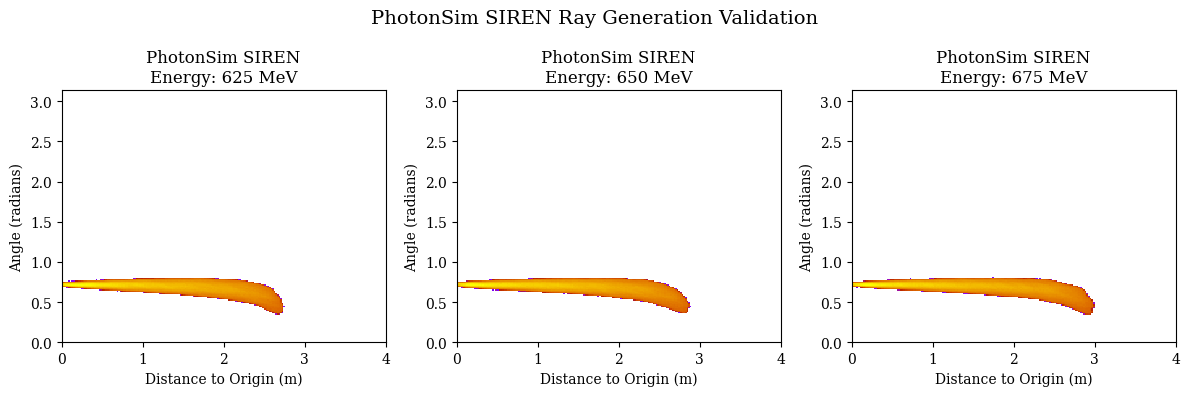

✅ Single energy comparison completed


In [8]:
# Generate rays for comparison energies
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

energies = [625, 650, 675]  # Same energies as original

for i, energy in enumerate(energies):
    print(f"Generating rays for energy {energy} MeV...")
    
    # Use the new PhotonSim function
    ray_vectors, ray_origins, photon_weights = photonsim_differentiable_get_rays(
        origin, direction, energy, Nphot, photonsim_predictor, table_data, key
    )
    
    ranges = jnp.linalg.norm(ray_origins - origin, axis=1)
    angles = calculate_opening_angles(ray_vectors, direction)
    
    h = axes[i].hist2d(
        ranges, 
        angles,
        weights=photon_weights.squeeze(), 
        bins=[200, 200], 
        cmap='gnuplot',
        norm=LogNorm(vmin=1),
        range=[[0, 4], [0, 3.14]]
    )

    axes[i].set_ylabel('Angle (radians)')
    axes[i].set_xlabel('Distance to Origin (m)')
    axes[i].set_title(f'PhotonSim SIREN\nEnergy: {energy} MeV')

fig.patch.set_facecolor('white')
fig.suptitle('PhotonSim SIREN Ray Generation Validation', fontsize=14)
fig.tight_layout()
plt.show()

print("✅ Single energy comparison completed")

## Energy Sweep Validation

Generate a comprehensive sweep across multiple energies to validate the PhotonSim model behavior.

Generating energy sweep from 300 to 900 MeV...
Processing energy 300 MeV (1/15)...
Processing energy 343 MeV (2/15)...
Processing energy 386 MeV (3/15)...
Processing energy 429 MeV (4/15)...
Processing energy 471 MeV (5/15)...
Processing energy 514 MeV (6/15)...
Processing energy 557 MeV (7/15)...
Processing energy 600 MeV (8/15)...
Processing energy 643 MeV (9/15)...
Processing energy 686 MeV (10/15)...
Processing energy 729 MeV (11/15)...
Processing energy 771 MeV (12/15)...
Processing energy 814 MeV (13/15)...
Processing energy 857 MeV (14/15)...
Processing energy 900 MeV (15/15)...
✅ Energy sweep completed and saved to photonsim_siren_ray_generation.png


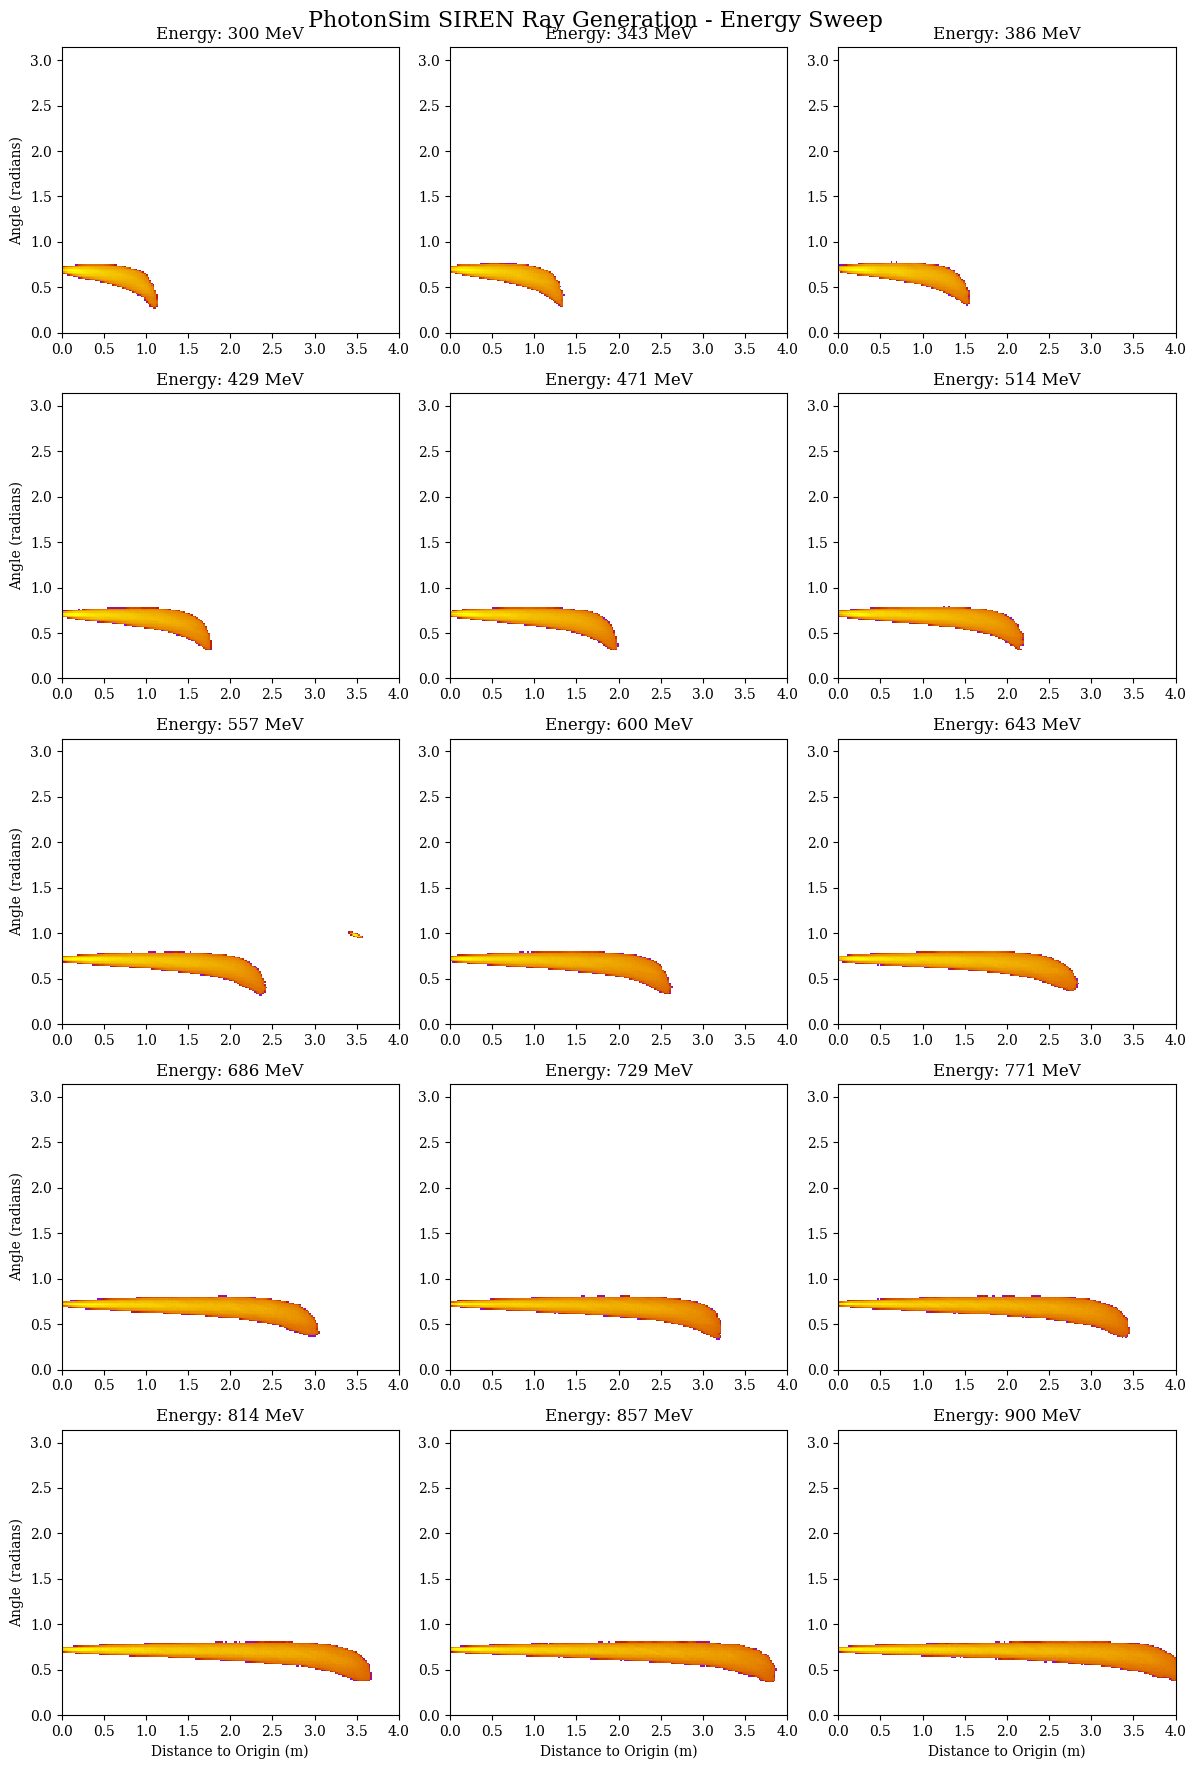

In [9]:
# Create energy sweep (using PhotonSim energy range)
fig, axes = plt.subplots(5, 3, figsize=(12, 18))

# Use energies in the PhotonSim training range [100, 1000] MeV
energies = np.linspace(300, 900, 15)

# Flatten the axes array to make it easier to iterate over
axes_flat = axes.flatten()

print(f"Generating energy sweep from {energies[0]:.0f} to {energies[-1]:.0f} MeV...")

for i, energy in enumerate(energies):
    print(f"Processing energy {energy:.0f} MeV ({i+1}/{len(energies)})...")
    
    # Generate rays using PhotonSim model
    ray_vectors, ray_origins, photon_weights = photonsim_differentiable_get_rays(
        origin, direction, energy, Nphot, photonsim_predictor, table_data, key
    )
    
    ranges = jnp.linalg.norm(ray_origins - origin, axis=1)
    angles = calculate_opening_angles(ray_vectors, direction)
    
    h = axes_flat[i].hist2d(
        ranges, 
        angles,
        weights=photon_weights.squeeze(),
        bins=[200, 200],
        cmap='gnuplot',
        norm=LogNorm(vmin=0.5),
        range=[[0, 4], [0, 3.14]]
    )
    
    # Add energy value to the title of each subplot
    axes_flat[i].set_title(f'Energy: {energy:.0f} MeV')
    
    # Only add y-label for leftmost plots
    if i % 3 == 0:
        axes_flat[i].set_ylabel('Angle (radians)')
    
    # Only add x-label for bottom plots
    if i >= 12:
        axes_flat[i].set_xlabel('Distance to Origin (m)')

fig.patch.set_facecolor('white')
fig.suptitle('PhotonSim SIREN Ray Generation - Energy Sweep', fontsize=16)
fig.tight_layout()

# Save the plot
output_path = 'photonsim_siren_ray_generation.png'
fig.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✅ Energy sweep completed and saved to {output_path}")

plt.show()

## Model Comparison and Validation

Compare key characteristics between the old PyTorch model and the new PhotonSim model.


Detailed analysis for energy 650 MeV:
  Number of photons generated: 1,000,000
  Photon weight statistics:
    Min: 13.193481
    Max: 538.452942
    Mean: 92.149551
    Std: 72.845543
  Range statistics:
    Min: 0.000 m
    Max: 2.880 m
    Mean: 1.655 m
  Angle statistics:
    Min: 20.72 degrees
    Max: 45.59 degrees
    Mean: 38.41 degrees


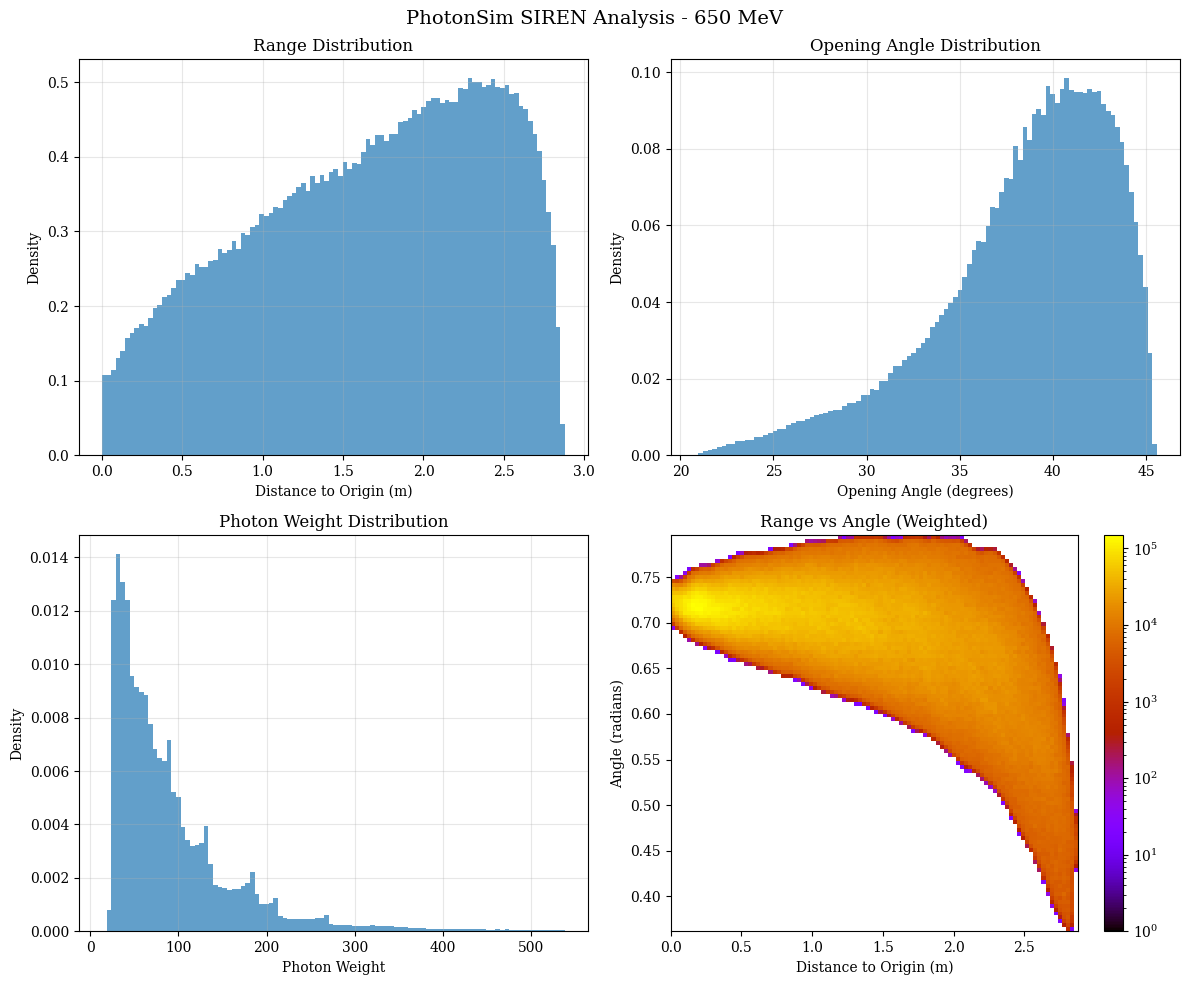

✅ Detailed analysis completed


In [10]:
# Test specific energy points and analyze the distribution
test_energy = 650  # MeV
print(f"\nDetailed analysis for energy {test_energy} MeV:")

ray_vectors, ray_origins, photon_weights = photonsim_differentiable_get_rays(
    origin, direction, test_energy, Nphot, photonsim_predictor, table_data, key
)

ranges = jnp.linalg.norm(ray_origins - origin, axis=1)
angles = calculate_opening_angles(ray_vectors, direction)

print(f"  Number of photons generated: {len(photon_weights):,}")
print(f"  Photon weight statistics:")
print(f"    Min: {photon_weights.min():.6f}")
print(f"    Max: {photon_weights.max():.6f}")
print(f"    Mean: {photon_weights.mean():.6f}")
print(f"    Std: {photon_weights.std():.6f}")
print(f"  Range statistics:")
print(f"    Min: {ranges.min():.3f} m")
print(f"    Max: {ranges.max():.3f} m")
print(f"    Mean: {ranges.mean():.3f} m")
print(f"  Angle statistics:")
print(f"    Min: {np.degrees(angles.min()):.2f} degrees")
print(f"    Max: {np.degrees(angles.max()):.2f} degrees")
print(f"    Mean: {np.degrees(angles.mean()):.2f} degrees")

# Create detailed plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Range distribution
axes[0, 0].hist(ranges, bins=100, alpha=0.7, density=True)
axes[0, 0].set_xlabel('Distance to Origin (m)')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Range Distribution')
axes[0, 0].grid(True, alpha=0.3)

# Angle distribution
axes[0, 1].hist(np.degrees(angles), bins=100, alpha=0.7, density=True)
axes[0, 1].set_xlabel('Opening Angle (degrees)')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Opening Angle Distribution')
axes[0, 1].grid(True, alpha=0.3)

# Weight distribution
axes[1, 0].hist(photon_weights, bins=100, alpha=0.7, density=True)
axes[1, 0].set_xlabel('Photon Weight')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Photon Weight Distribution')
axes[1, 0].grid(True, alpha=0.3)

# 2D distribution (main result)
h = axes[1, 1].hist2d(
    ranges, angles, 
    weights=photon_weights.squeeze(), 
    bins=[100, 100], 
    cmap='gnuplot',
    norm=LogNorm(vmin=1)
)
axes[1, 1].set_xlabel('Distance to Origin (m)')
axes[1, 1].set_ylabel('Angle (radians)')
axes[1, 1].set_title('Range vs Angle (Weighted)')
plt.colorbar(h[3], ax=axes[1, 1])

fig.suptitle(f'PhotonSim SIREN Analysis - {test_energy} MeV', fontsize=14)
fig.tight_layout()
plt.show()

print("✅ Detailed analysis completed")

## Summary

This notebook successfully demonstrates ray generation using the PhotonSim-trained SIREN model. The `photonsim_differentiable_get_rays` function:

1. **Uses the PhotonSim SIREN model**: Loads and uses the newly trained model via `SIRENPredictor`
2. **Maintains compatibility**: Uses the same grid structure and sampling approach as the original
3. **Adapts input format**: Converts between the old coordinate system and PhotonSim's [energy, angle, distance] format
4. **Preserves functionality**: Generates rays with proper weighting and angular distributions

### Key Differences from Original:
- Uses `SIRENPredictor.predict_batch()` instead of direct model inference
- Converts coordinate systems to match PhotonSim training format
- Adapts energy ranges and scaling factors for the new model
- Maintains the same sampling and noise injection strategy

The generated ray distributions should reflect the improved physics modeling of the PhotonSim-trained SIREN network.